# DBSCAN clustering to reduce spatial data set size

This notebook reduces the size of a spatial data set by clustering with DBSCAN. More info: http://geoffboeing.com/2014/08/visualizing-summer-travels/

You might also be interested in [this notebook](https://github.com/gboeing/data-visualization/blob/master/location-history/google-location-history-cluster.ipynb) that uses this technique to cluster 1.2 million spatial data points and [this write-up](http://geoffboeing.com/2016/06/mapping-everywhere-ever-been/) of that project. Also see [here](https://en.wikipedia.org/wiki/Earth_radius#Mean_radius) for the number of kilometers in one radian.

In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, time
from sklearn.cluster import DBSCAN
from sklearn import metrics
from geopy.distance import great_circle
from shapely.geometry import MultiPoint
%matplotlib inline

In [2]:
# define the number of kilometers in one radian
kms_per_radian = 6371.0088

In [3]:
# load the data set
df = pd.read_csv('data/summer-travel-gps-full.csv', encoding='utf-8')
df.head()

,lat,lon,date,city,country
0,51.481292,-0.451011,05/14/2014 09:07,West Drayton,United Kingdom
1,51.474005,-0.450999,05/14/2014 09:22,Hounslow,United Kingdom
2,51.478199,-0.446081,05/14/2014 10:51,Hounslow,United Kingdom
3,51.478199,-0.446081,05/14/2014 11:24,Hounslow,United Kingdom
4,51.474146,-0.451562,05/14/2014 11:38,Hounslow,United Kingdom


The scikit-learn DBSCAN haversine distance metric requires data in the form of [latitude, longitude] and both inputs and outputs are in units of radians.

### Compute DBSCAN

  - `eps` is the physical distance from each point that forms its neighborhood
  - `min_samples` is the min cluster size, otherwise it's noise - set to 1 so we get no noise
  
Extract the lat, lon columns into a numpy matrix of coordinates, then convert to radians when you call `fit`, for use by scikit-learn's haversine metric.

In [4]:
# represent points consistently as (lat, lon)
coords = df.as_matrix(columns=['lat', 'lon'])

# define epsilon as 1.5 kilometers, converted to radians for use by haversine
epsilon = 1.5 / kms_per_radian

In [5]:
start_time = time.time()
db = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_

# get the number of clusters
num_clusters = len(set(cluster_labels))

# all done, print the outcome
message = 'Clustered {:,} points down to {:,} clusters, for {:.1f}% compression in {:,.2f} seconds'
print(message.format(len(df), num_clusters, 100*(1 - float(num_clusters) / len(df)), time.time()-start_time))
print('Silhouette coefficient: {:0.03f}'.format(metrics.silhouette_score(coords, cluster_labels)))

Clustered 1,759 points down to 138 clusters, for 92.2% compression in 0.05 seconds
Silhouette coefficient: 0.652


In [6]:
# turn the clusters in to a pandas series, where each element is a cluster of points
clusters = pd.Series([coords[cluster_labels==n] for n in range(num_clusters)])

### Find the point in each cluster that is closest to its centroid

DBSCAN clusters may be non-convex. This technique just returns one representative point from each cluster. First get the lat,lon coordinates of the cluster's centroid (shapely represents the *first* coordinate in the tuple as `x` and the *second* as `y`, so lat is `x` and lon is `y` here). Then find the member of the cluster with the smallest great circle distance to the centroid.

In [7]:
def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)

centermost_points = clusters.map(get_centermost_point)

In [8]:
# unzip the list of centermost points (lat, lon) tuples into separate lat and lon lists
lats, lons = zip(*centermost_points)

# from these lats/lons create a new df of one representative point for each cluster
rep_points = pd.DataFrame({'lon':lons, 'lat':lats})
rep_points.tail()

,lat,lon
133,37.933913,23.945805
134,40.980462,28.820527
135,41.033193,28.982041
136,41.014963,29.010762
137,48.356285,11.791710


In [9]:
# pull row from original data set where lat/lon match the lat/lon of each row of representative points
# that way we get the full details like city, country, and date from the original dataframe
rs = rep_points.apply(lambda row: df[(df['lat']==row['lat']) & (df['lon']==row['lon'])].iloc[0], axis=1)
rs.to_csv('data/summer-travel-gps-dbscan.csv', encoding='utf-8')
rs.tail()

,lat,lon,date,city,country
133,37.933913,23.945805,07/06/2014 17:27,Attica,Greece
134,40.980462,28.820527,07/06/2014 21:27,Istanbul,Turkey
135,41.033193,28.982041,07/08/2014 15:30,Istanbul,Turkey
136,41.014963,29.010762,07/07/2014 16:56,Istanbul,Turkey
137,48.356285,11.791710,07/09/2014 13:17,Munich,Germany


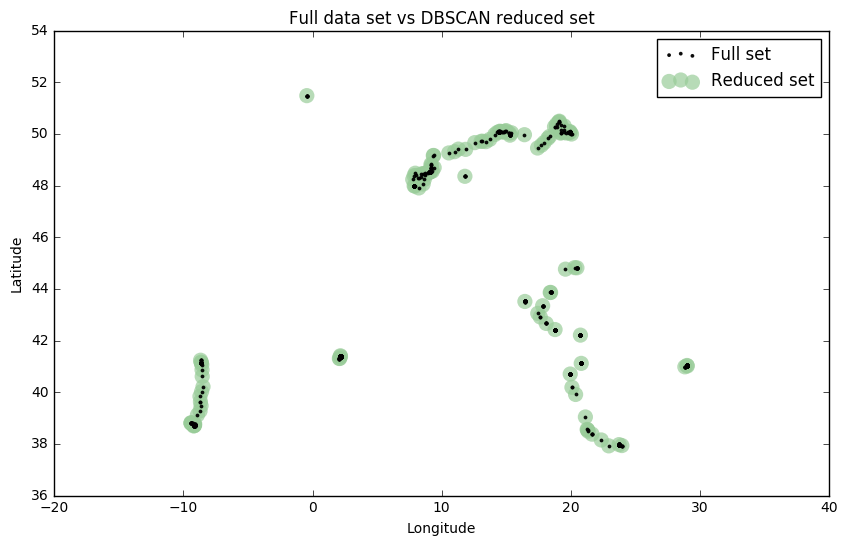

In [10]:
# plot the final reduced set of coordinate points vs the original full set
fig, ax = plt.subplots(figsize=[10, 6])
rs_scatter = ax.scatter(rs['lon'], rs['lat'], c='#99cc99', edgecolor='None', alpha=0.7, s=120)
df_scatter = ax.scatter(df['lon'], df['lat'], c='k', alpha=0.9, s=3)
ax.set_title('Full data set vs DBSCAN reduced set')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend([df_scatter, rs_scatter], ['Full set', 'Reduced set'], loc='upper right')
plt.show()